# Milestone 1: Data acquisition, Data preparation

# 1. Data Source, Installation and Data Integration

The data that will be used in the development of this project is the [Dataset of Speech Production in intracranial Electroencephalography](https://www.nature.com/articles/s41597-022-01542-9), this dataset can be downloaded from [here](https://osf.io/nrgx6/download) and then was uploaded to google drive.

The dataset is based on 10 participants reading out individual words while being measured his intracranial EEG from a total of 1103 electrodes. It has a high temporal resolution and coverage of a large variety of cortical and sub-cortical brain regions, can help in understanding the speech production process better.

In [1]:
# Install every library that we will need for the development of the project

!pip install numpy scipy scikit-learn pandas pynwb nilearn nibabel RutishauserLabtoNWB pytorch-lightning --quiet


In [2]:
import numpy as np
import scipy
import sklearn
import pandas as pd
import pynwb
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting
import RutishauserLabtoNWB as RLab

In [3]:
import pytorch_lightning as pl

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms

In [4]:
# Give permission to acces Google Drive cause there is where the Zip File is
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/"


'Colab Notebooks'   Dset   SingleWordProductionDutch-iBIDS.zip


In [6]:
# Let's unzip the file
!unzip -o  "/content/drive/My Drive/SingleWordProductionDutch-iBIDS.zip"


Archive:  /content/drive/My Drive/SingleWordProductionDutch-iBIDS.zip
  inflating: SingleWordProductionDutch-iBIDS/dataset_description.json  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_aparc.a2009s+aseg.mgz  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_brain.mgz  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_lh_pial.mat  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_rh_pial.mat  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_wmparc.mgz  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-02/sub-02_aparc.a2009s+aseg.mgz  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-02/sub-02_brain.mgz  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-02/sub-02_lh_pial.mat  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-02/sub-02_rh_pial.mat  
  inflating: SingleWordProductionDutch-iBIDS/derivatives/sub-02/sub-02_wmparc.

In [7]:
# Let's check if the file is already unziped
!ls


drive  sample_data  SingleWordProductionDutch  SingleWordProductionDutch-iBIDS


In [8]:
# Let's lists the files and directories in the current directory
!ls "SingleWordProductionDutch-iBIDS"


dataset_description.json  participants.tsv  sub-02  sub-05  sub-08
derivatives		  README	    sub-03  sub-06  sub-09
participants.json	  sub-01	    sub-04  sub-07  sub-10


## 1.2  We Clone the repository with the Scripts, so we can work with the intracranial EEG data

In [9]:
!git clone https://github.com/neuralinterfacinglab/SingleWordProductionDutch.git


fatal: destination path 'SingleWordProductionDutch' already exists and is not an empty directory.


# 2. Data Exploration and Visualization

Our dataset has a structure that follows the BIDS (Brain Imaging Data Structure) format, which is a standard in organizing neuroimaging and neurophysiology data.

So we'll approach the data in the next way:
1. Metadata Exploration
2. Individual Participant Data
3. Derivatives Data

## 2.1. Metadata Exploration
The root folder contains:
- metadata of the participants (participants.tsv)
- subject specific data folders (i.e., sub-01)
- derivatives folder

### 2.1.1 README

In [10]:
# Read the README in case some important information is needed for the dataset evaluation

with open("SingleWordProductionDutch-iBIDS/README", "r") as file:
    readme_contents = file.read()

print(readme_contents)


﻿References
----------
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896). https://doi.org/10.21105/joss.01896

Holdgraf, C., Appelhoff, S., Bickel, S., Bouchard, K., D'Ambrosio, S., David, O., … Hermes, D. (2019). iEEG-BIDS, extending the Brain Imaging Data Structure specification to human intracranial electrophysiology. Scientific Data, 6, 102. https://doi.org/10.1038/s41597-019-0105-7




### 2.1.2 Dataset Description

In [11]:
# Read the dataset description as an informative
import json
with open("SingleWordProductionDutch-iBIDS/dataset_description.json", "r") as file:
    dataset_description = json.load(file)

# Display the contents of the JSON file
dataset_description


{'Name': 'SingleWordProductionDutch-iBIDS',
 'BIDSVersion': '1.7.0',
 'DatasetType': 'raw',
 'Authors': ['Verwoert M', 'Herff C']}

### 2.1.3 Participants

In [12]:
# Read for general demographic information of participants
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read and display participants.tsv
participants_tsv = pd.read_csv("SingleWordProductionDutch-iBIDS/participants.tsv", sep='\t')
participants_tsv


,participant_id,age,sex,hand
0,sub-01,20,F,NaN
1,sub-02,43,M,NaN
2,sub-03,24,M,NaN
3,sub-04,46,F,NaN
4,sub-05,50,F,NaN
5,sub-06,16,M,NaN
6,sub-07,47,M,NaN
7,sub-08,22,F,NaN
8,sub-09,20,F,NaN
9,sub-10,36,M,NaN


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(participants_tsv, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(participants_tsv, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(participants_tsv, *['sex'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(participants_tsv, *['age', 'sex'], **{'inner': 'stick'})
chart

In [13]:
# Read to understand the metadata of "participants.tsv"

# Open and read participants.json
with open("SingleWordProductionDutch-iBIDS/participants.json", "r") as file:
    participants_json = json.load(file)

participants_json


{'participant_id': {'Description': 'Unique participant identifier'},
 'age': {'Description': 'Age of the participant at time of testing',
  'Units': 'years'},
 'sex': {'Description': 'Biological sex of the participant',
  'Levels': {'F': 'female', 'M': 'male'}},
 'hand': {'Description': 'Handedness of the participant',
  'Levels': {'R': 'right', 'L': 'left', 'A': 'ambidextrous'}}}

In [14]:
# Create a dataframe of the dictionary for better understanding

# Convert nested dictionary to a list of dictionaries for creating a DataFrame
participants_json_list = []
for key, value in participants_json.items():
    row = {'key': key}
    row.update(value)
    participants_json_list.append(row)

# Convert to DataFrame
df = pd.DataFrame(participants_json_list)
df


,key,Description,Units,Levels
0,participant_id,Unique participant identifier,NaN,NaN
1,age,Age of the participant at time of testing,years,NaN
2,sex,Biological sex of the participant,NaN,"{'F': 'female', 'M': 'male'}"
3,hand,Handedness of the participant,NaN,"{'R': 'right', 'L': 'left', 'A': 'ambidextrous'}"


### 2.1.4 Derivatives

In [15]:
!ls "SingleWordProductionDutch-iBIDS/derivatives"


sub-01	sub-02	sub-03	sub-04	sub-05	sub-06	sub-07	sub-08	sub-09	sub-10


## 2.2 Individual Participant Data
The subject specific folders contain .tsv files with information about:
- the implanted electrode coordinates (_electrodes.tsv)
- recording montage (_channels.tsv)
- event markers (_events.tsv)
- The _ieeg.nwb file contains three raw data streams as timeseries (iEEG, Audio and Stimulus), which are located in the acquisition container.
- Descriptions of recording aspects and of specific .tsv columns are provided in correspondingly named .json files (i.e., participants.json).

We will choose one participant for the development of the project, and with his data we will realize the training, validation and testing for the set of a single speaker.

The election of the individual participant will be random, so the selected participant is **sub-01**



### 2.2.1 The implanted electrode coordinates

In [16]:
# 1. Load the electrodes.tsv for sub-01
electrodes_tsv_path = "/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_space-ACPC_electrodes.tsv"
electrodes_data = pd.read_csv(electrodes_tsv_path, sep='\t')
display(electrodes_data)


,name,x,y,z,size
0,LA1,-33.957159,-74.693203,9.042846,5
1,LA2,-36.957022,-72.882019,9.091264,5
2,LA3,-39.956885,-71.070836,9.139682,5
3,LA4,-42.956748,-69.259652,9.188100,5
4,LA5,-45.956610,-67.448468,9.236518,5
5,LA6,-48.956473,-65.637284,9.284936,5
6,LA7,-51.956336,-63.826101,9.333354,5
7,LA8,-54.956199,-62.014917,9.381771,5
8,LB1,-21.785583,-53.110547,13.640142,5
9,LB2,-24.978944,-53.167355,14.962851,5


None

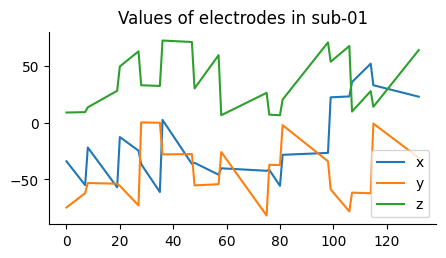

In [17]:
def value_plot(df, columns, figscale=1):
    for col in columns:
        df[col].plot(kind='line', title='Values of electrodes in sub-01',figsize=(5*figscale, 2.5*figscale), label=col)

    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.legend(loc='best')

electrodes_chart = value_plot(electrodes_data, ['x', 'y', 'z'])
display (electrodes_chart)

None

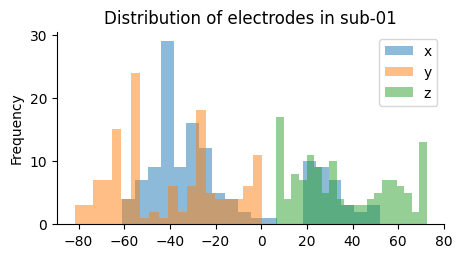

In [18]:
def histogram(df, columns, num_bins=20, figscale=1):
    for col in columns:
        df[col].plot(kind='hist', bins=num_bins, title="Distribution of electrodes in sub-01",figsize=(5*figscale, 2.5*figscale), alpha=0.5, label=col)

    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.legend(loc='best')

electrodes_distributionchart = histogram(electrodes_data, ['x', 'y', 'z'])
display(electrodes_distributionchart)


### 2.2.2 Recording montage

In [19]:
# 2. Load the channels.tsv for sub-01
channels_tsv_path = "/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_channels.tsv"
channels_data = pd.read_csv(channels_tsv_path, sep='\t')
display(channels_data)

,name,type,units,low_cutoff,high_cutoff,description,sampling_frequency,status
0,LA1,SEEG,µV,0.0,512.0,Left-Cerebral-White-Matter,1024.0,NaN
1,LA2,SEEG,µV,0.0,512.0,ctx_lh_G_and_S_occipital_inf,1024.0,NaN
2,LA3,SEEG,µV,0.0,512.0,Unknown,1024.0,NaN
3,LA4,SEEG,µV,0.0,512.0,ctx_lh_S_occipital_ant,1024.0,NaN
4,LA5,SEEG,µV,0.0,512.0,ctx_lh_S_occipital_ant,1024.0,NaN
5,LA7,SEEG,µV,0.0,512.0,Unknown,1024.0,NaN
6,LA8,SEEG,µV,0.0,512.0,Unknown,1024.0,NaN
7,LO1,SEEG,µV,0.0,512.0,Left-Cerebral-White-Matter,1024.0,NaN
8,LO2,SEEG,µV,0.0,512.0,Left-Cerebral-White-Matter,1024.0,NaN
9,LO3,SEEG,µV,0.0,512.0,Left-Cerebral-White-Matter,1024.0,NaN


### 2.2.3 Event markers

In [20]:
# 3. Load the events.tsv for sub-01
events_tsv_path = "/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_events.tsv"
events_data = pd.read_csv(events_tsv_path, sep='\t')
display(events_data)


,onset,duration,trial_type,value,sample
0,0.000000,1.999023,word,helft,0
1,1.999023,1.003906,fixation,+,2047
2,3.002930,1.993164,word,hierop,3075
3,4.996094,1.008789,fixation,+,5116
4,6.004883,1.998047,word,stiekem,6149
5,8.002930,1.008789,fixation,+,8195
6,9.011719,1.990234,word,en,9228
7,11.001953,1.009766,fixation,+,11266
8,12.011719,1.994141,word,zevenduizend,12300
9,14.005859,1.010742,fixation,+,14342


### 2.2.4 The _ieeg.nwb file (iEEG, Audio and Stimulus)

In [21]:
# 4. Load the .nwb file
# We use NWBHDF5IO to read the data stored in NWB files, accessing and analyzinge the neurophysiological data inside
from pynwb import NWBHDF5IO

ieeg_nwb_path = "/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_ieeg.nwb"
with NWBHDF5IO(ieeg_nwb_path, 'r') as io:
  nwbfile = io.read()

  # List the names of all data interfaces in the file
  print(nwbfile.acquisition)

  # Extract data for each interface
  audio_data_sample = nwbfile.acquisition['Audio'].data[:15]
  stimulus_data_sample = nwbfile.acquisition['Stimulus'].data[:15]
  ieeg_data_sample = nwbfile.acquisition['iEEG'].data[:15]

  print("Audio data:", audio_data_sample)
  print()
  print("Stimulus data:", stimulus_data_sample)
  print()
  print("iEEG data (first 5 channels):", ieeg_data_sample[:, :5])

{'Audio': Audio pynwb.base.TimeSeries at 0x137203587628000
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <HDF5 dataset "data": shape (14414532,), type "<f8">
  description: recorded audio aligned to sEEG data
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (14414532,), type "<f8">
  timestamps_unit: seconds
, 'Stimulus': Stimulus pynwb.base.TimeSeries at 0x137203587628672
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <StrDataset for HDF5 dataset "data": shape (307511,), type "|O">
  description: word presented on screen during each sEEG sample
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (307511,), type "<f8">
  timestamps_unit: seconds
, 'iEEG': iEEG pynwb.base.TimeSeries at 0x137203587989856
Fields:
  comments: no comments
  continuity: continuous
  conversion: 1.0
  data: <HDF5 dataset "data": shape (307511, 127), 

In [22]:
import h5py #HDF5 is designed to store and organize large amounts of numerical data

with h5py.File(ieeg_nwb_path, 'r') as nwbfile:

# Print the root-level keys in the HDF5 file
  print(list(nwbfile.keys()))


['acquisition', 'analysis', 'file_create_date', 'general', 'identifier', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time']


### 2.2.5 Descriptions of recording aspects and of specific .tsv columns

In [23]:
# 5. Load the first JSON file

import json
path_to_json = "/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_space-ACPC_coordsystem.json"
with open(path_to_json, 'r') as json_file:
    data_description = json.load(json_file)

print(json.dumps(data_description, indent = 2))

{
  "iEEGCoordinateSystem": "ACPC",
  "iEEGCoordinateSystemDescription": "The origin of the coordinate system is at the Anterior Commissure and the negative y-axis is passing through the Posterior Commissure. The positive z-axis is passing through a mid-hemispheric point in the superior direction.",
  "iEEGCoordinateUnits": "mm"
}


In [24]:
# 5. Load the second JSON file

path_to_json2= '/content/SingleWordProductionDutch-iBIDS/sub-01/ieeg/sub-01_task-wordProduction_ieeg.json'

with open(path_to_json2, 'r') as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=4))

{
    "TaskName": "wordProduction",
    "Manufacturer": "BrainProducts",
    "PowerLineFrequency": 50.0,
    "SamplingFrequency": 1024.0,
    "SoftwareFilters": "n/a",
    "RecordingDuration": 300.302734375,
    "RecordingType": "continuous",
    "iEEGReference": "LI1",
    "ECOGChannelCount": 0,
    "SEEGChannelCount": 127,
    "EEGChannelCount": 0,
    "EOGChannelCount": 0,
    "ECGChannelCount": 0,
    "EMGChannelCount": 0,
    "MiscChannelCount": 0,
    "TriggerChannelCount": 0,
    "iEEGGround": "RY12",
    "TaskDescription": "Speech production of 100 unique Dutch words",
    "Instructions": "Speak the word presented on the screen out-loud"
}


## 2.3 Derivatives Data
The derivatives folder contains:
- the pial surface cortical meshes of the right (_rh_pial.mat) and left (_lh_pial.mat) hemisphere
- the brain anatomy (_brain.mgz)
- the Destrieux atlas (_aparc.a2009s + aseg.mgz)
- a white matter atlas (_wmparc.mgz) per subject, derived from the Freesurfer pipeline.

In [25]:
!ls SingleWordProductionDutch-iBIDS/derivatives


sub-01	sub-02	sub-03	sub-04	sub-05	sub-06	sub-07	sub-08	sub-09	sub-10


### 2.3.1 Pial Surface Data

In [26]:
# Explore Pial Surface Data
import scipy.io

rh_pial_path = "/content/SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_rh_pial.mat"
lh_pial_path = "/content/SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_lh_pial.mat"

rh_pial = scipy.io.loadmat(rh_pial_path)
lh_pial = scipy.io.loadmat(lh_pial_path)

# Let's inspect the keys and structure of the loaded data
print(rh_pial.keys())
print(lh_pial.keys())


dict_keys(['__header__', '__version__', '__globals__', 'cortex'])
dict_keys(['__header__', '__version__', '__globals__', 'cortex'])


### 2.3.2 Brain Anatomy

In [27]:
# Explore Brain Anatomy

brain_data_path = "/content/SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_brain.mgz"
brain_data = nib.load(brain_data_path)

In [28]:
# Display the shape of the data
print("Data shape:", brain_data.shape)

# Display header information
print(brain_data.header)

# Get the actual data as a numpy array (if needed)
brain_numpy_data = brain_data.get_fdata()


Data shape: (256, 256, 256)
<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 0
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [ -0.99998474  -4.         -18.        ]
tr           : 8.2481
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


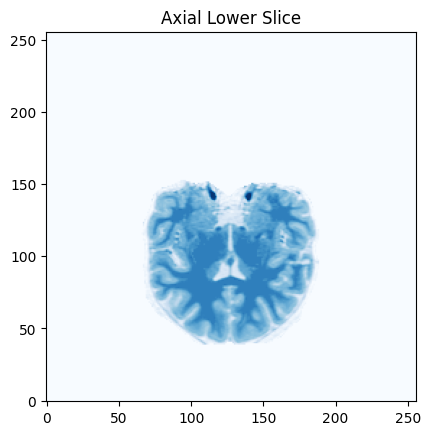

In [29]:
# Extract a 2D slice
axial_slice = brain_numpy_data[:, :, brain_numpy_data.shape[2] // 2]

plt.imshow(axial_slice.T, cmap="Blues", origin="lower")
plt.title("Axial Lower Slice")
plt.show()

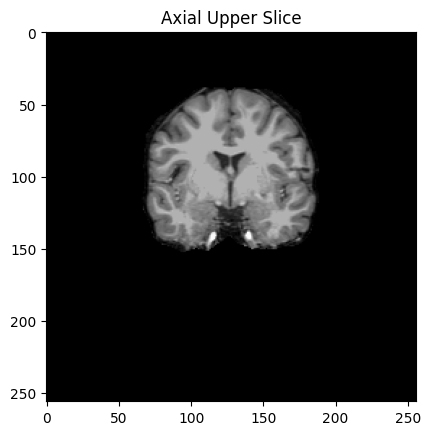

In [30]:
# Extract a 2D slice
axial_slice = brain_numpy_data[:, :, brain_numpy_data.shape[2] // 2]

plt.imshow(axial_slice.T, cmap="gray", origin="upper")
plt.title("Axial Upper Slice")
plt.show()

### 2.3.3 The Destrieux atlas

In [31]:
destrieux_atlas_path = "/content/SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_aparc.a2009s+aseg.mgz"
destrieux_atlas_data = nib.load(destrieux_atlas_path)

In [32]:
# Get the data array from the atlas
atlas_array = destrieux_atlas_data.get_fdata()

# Print the shape of the data to understand its dimensions
print(atlas_array.shape)

# Print header information to understand metadata
print(destrieux_atlas_data.header)


(256, 256, 256)
<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 1
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [ -0.99998474  -4.         -18.        ]
tr           : 8.2481
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


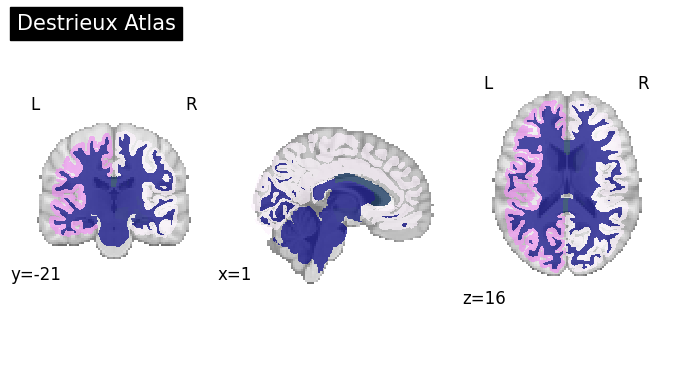

In [33]:
# Convert the data to a 3D numpy array
atlas_img = np.asarray(atlas_array, dtype=np.int32)

# Display the atlas using nilearn's plotting function
plotting.plot_roi(destrieux_atlas_data, draw_cross=False, title="Destrieux Atlas")
plotting.show()


### 2.3.4  A white matter atlas

In [34]:
import nibabel as nib

wm_atlas_path = "/content/SingleWordProductionDutch-iBIDS/derivatives/sub-01/sub-01_wmparc.mgz"
wm_atlas_data = nib.load(wm_atlas_path)

In [35]:
# Extract data array from the atlas
wm_array = wm_atlas_data.get_fdata()

# Print the shape of the data
print(wm_array.shape)

# Print header information for metadata understanding
print(wm_atlas_data.header)


(256, 256, 256)
<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 1
dof          : 1
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Pxyz_c       : [ -0.99998474  -4.         -18.        ]
tr           : 8.2481
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


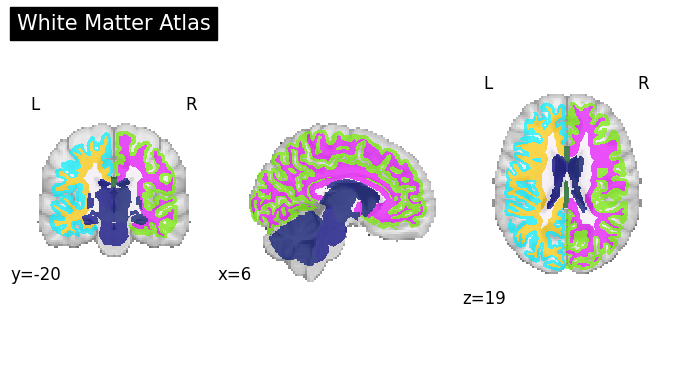

In [36]:
import numpy as np
from nilearn import plotting

# Convert the data to a 3D numpy array
wm_img = np.asarray(wm_array, dtype=np.int32)

# Display the atlas using nilearn's plotting function
plotting.plot_roi(wm_atlas_data, draw_cross=False, title="White Matter Atlas")
plotting.show()


# 3. Preparing data for training
- As we mention before, we filter the data so we are only using a single speaker sub-01.

Given the content of the NWBFile, there are three types of data under de acquisition field:
- Audio <class 'pynwb.base.TimeSeries'>
- Stimulus <class 'pynwb.base.TimeSeries'>
- iEEG <class 'pynwb.base.TimeSeries'>

iEEG stands for intracranial electroencephalography. It is a type of electroencephalography (EEG) where electrodes are placed directly on the exposed surface of the brain to record electrical activity. This is in contrast to traditional EEG where electrodes are placed on the scalp.

iEEG data is particularly valuable. Speech production involves multiple regions of the brain, including the motor cortex, Broca's area, and others. The high spatial resolution of iEEG allows for the nuanced study of how these regions interact during the task. This makes it an essential dataset for understanding brain mechanisms involved in speech, which can be of significance in our project.






# 3.1 Preparing audio

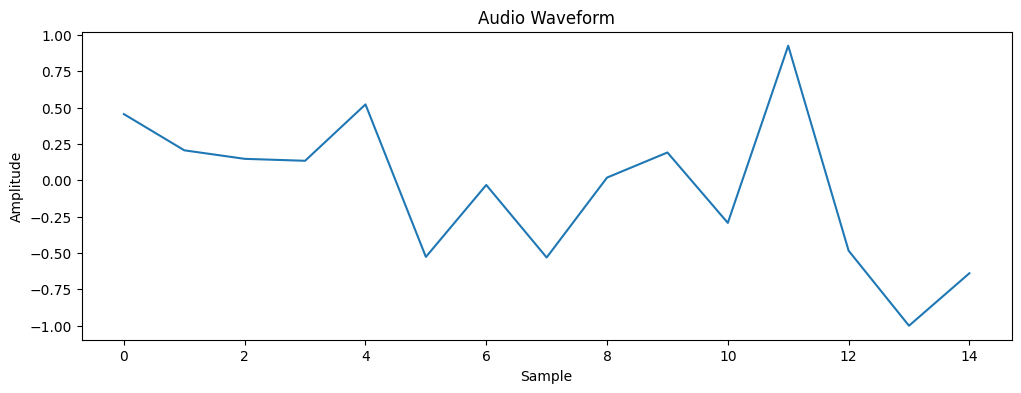

In [37]:
audio_data_np = np.array(audio_data_sample)
max_amplitude = np.max(np.abs(audio_data_np))
audio_data_normalized = audio_data_np / max_amplitude
audio_tensor = torch.tensor(audio_data_normalized, dtype=torch.float32)
batch_size = 1  # We might adjust the batch size
audio_tensor = audio_tensor.view(batch_size, -1)
audio_array = audio_tensor.squeeze().numpy()  # Squeeze removes dimensions of size 1 (in case batch_size is 1)
# Plot the audio waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_array)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

# 3.2 Preparing iEEG

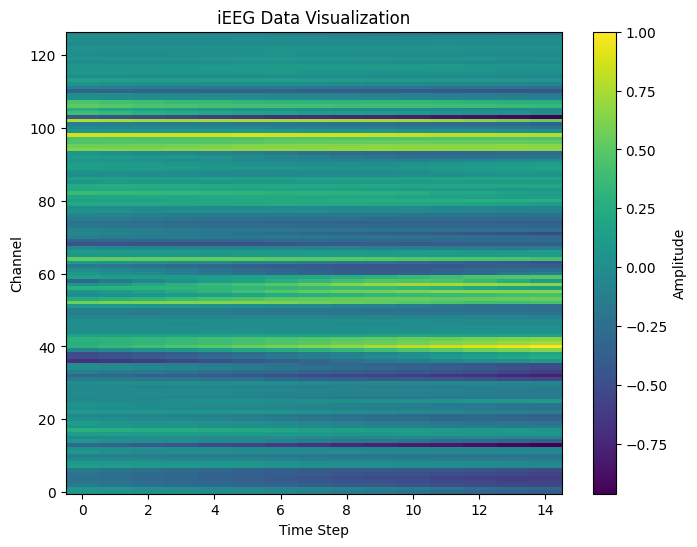

In [38]:
ieeg_data_np = np.array(ieeg_data_sample)
max_amplitude_ieeg = np.max(np.abs(ieeg_data_np))
ieeg_data_normalized = ieeg_data_np / max_amplitude_ieeg
ieeg_tensor = torch.tensor(ieeg_data_normalized, dtype=torch.float32)
# Visualize iEEG data
plt.figure(figsize=(8, 6))
plt.imshow(ieeg_tensor.T, aspect='auto', cmap='viridis', origin='lower')
plt.xlabel('Time Step')
plt.ylabel('Channel')
plt.title('iEEG Data Visualization')
plt.colorbar(label='Amplitude')
plt.show()